# Project Description. Industry

To optimize production costs, a steel mill has decided to reduce electricity consumption at the steel processing stage. To do this, it needs to control the temperature of the alloy. The task is to build a model that will predict it, the customer wants to use the developed model to simulate the technological process.

According to the customer's condition, the MAE value of the selected model should not exceed 6.8.

## Data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics
import torch
import torch.nn as nn

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
from sklearn.model_selection import cross_val_score


warnings.simplefilter("ignore", UserWarning)

RANDOM_STATE = 161023

In [2]:

db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-final'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string) 


In [4]:
print(dir(engine))

## Research and preparation of tables
### Table data_arc
The table contains data about the electrodes.

The following columns are specified in the documentation:

- `key` - lot number;
- `BeginHeat` - heating start time;
- `EndHeat` - time of heating end;
- `ActivePower` - active power value;
- `ReactivePower` - value of reactive power.

In [5]:
query = '''
SELECT *
FROM steel.data_arc
'''

data_arc = pd.read_sql_query(query, con=engine)
display(data_arc)
data_arc.info()


There are no skips. Let's convert the time to datetime format and find the total heating time in seconds, then remove unnecessary columns and look at the basic statistics 

In [6]:
data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S')
data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S')



In [7]:
data_arc['HeatTime'] = (data_arc['EndHeat'] - data_arc['BeginHeat']).dt.total_seconds()
data_arc = data_arc.drop(['BeginHeat','EndHeat'], axis=1)

In [8]:
data_arc.describe()

There are negative values in reactive power and heating time, which is incorrect. Let's look at the distribution

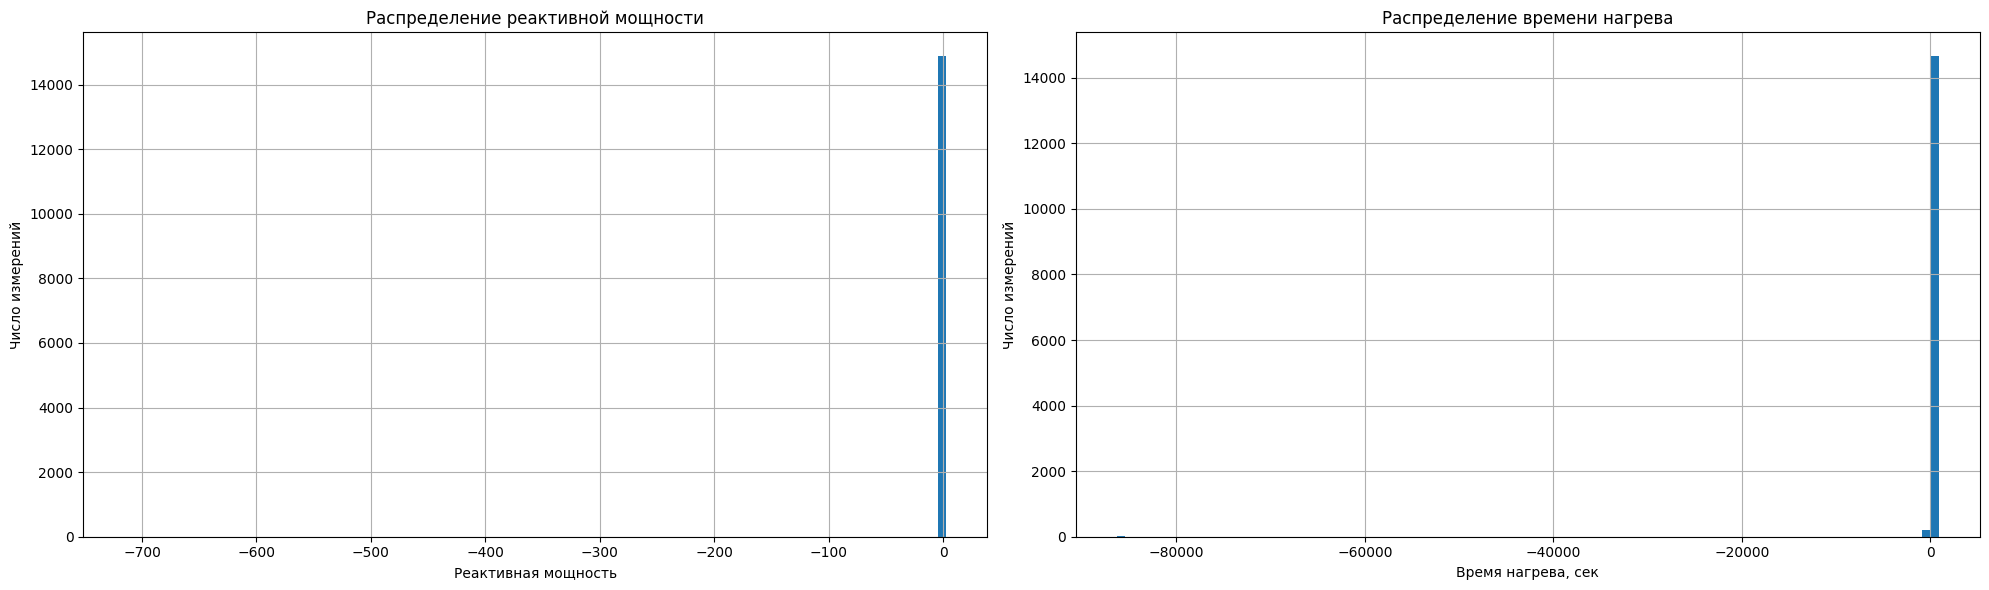

In [9]:

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Graph 1: Reactive power distribution
axs[0].hist(data_arc['ReactivePower'], bins=100)
axs[0].set_title('Распределение реактивной мощности')
axs[0].set_xlabel('Реактивная мощность')
axs[0].set_ylabel('Число измерений')
axs[0].grid(True)

# Graph 2: Heating time distribution
axs[1].hist(data_arc['HeatTime'], bins=100)
axs[1].set_title('Распределение времени нагрева')
axs[1].set_xlabel('Время нагрева, сек')
axs[1].set_ylabel('Число измерений')
axs[1].grid(True)

# Automatically adjust the fit to prevent headings, labels, etc. from overlapping.
plt.tight_layout()


plt.show()


In [10]:
data_arc = data_arc.query('ReactivePower > 0')


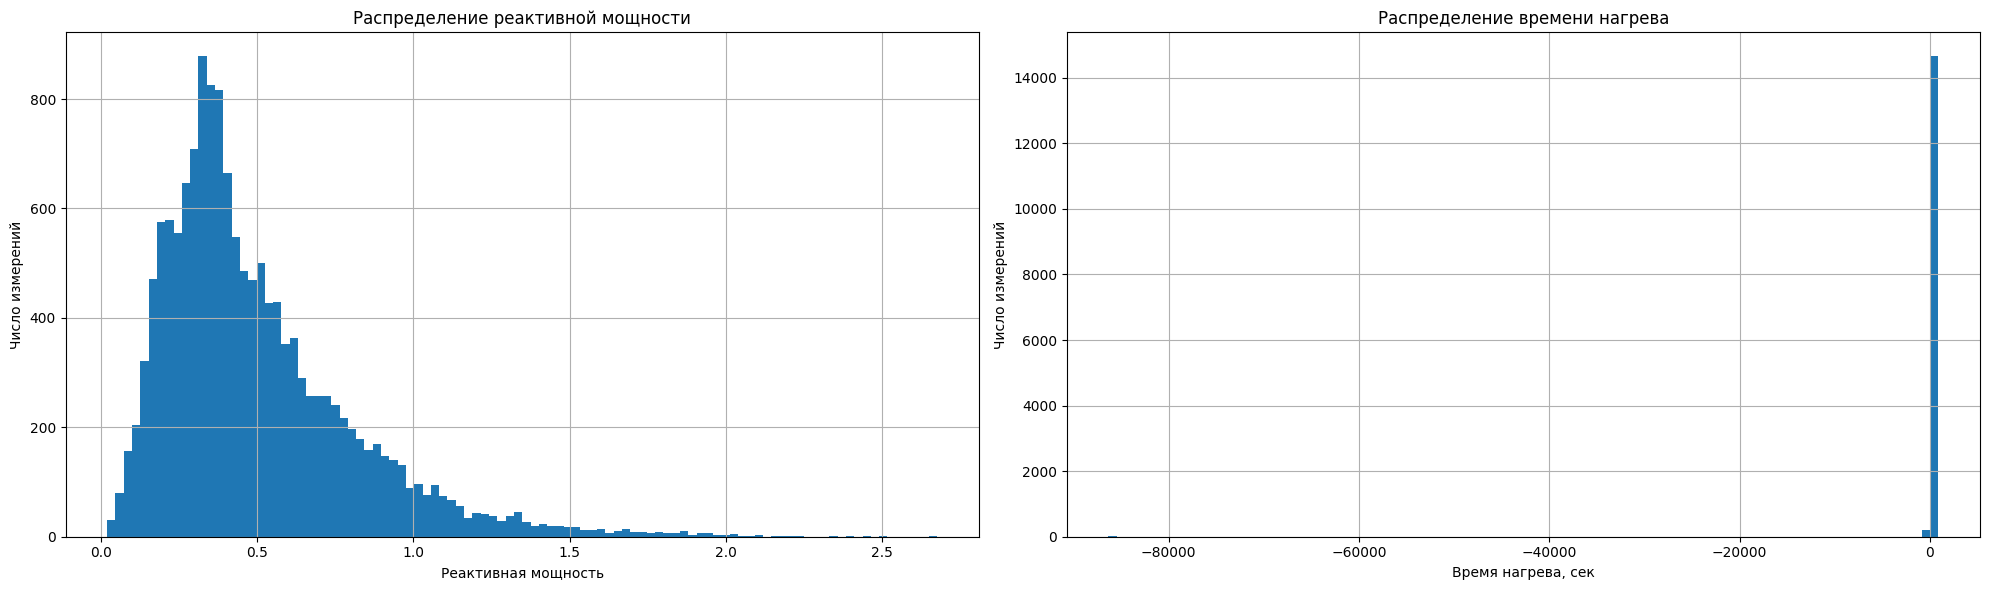

In [11]:

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Graph 1: Reactive power distribution
axs[0].hist(data_arc['ReactivePower'], bins=100)
axs[0].set_title('Распределение реактивной мощности')
axs[0].set_xlabel('Реактивная мощность')
axs[0].set_ylabel('Число измерений')
axs[0].grid(True)

# Graph 2: Heating time distribution
axs[1].hist(data_arc['HeatTime'], bins=100)
axs[1].set_title('Распределение времени нагрева')
axs[1].set_xlabel('Время нагрева, сек')
axs[1].set_ylabel('Число измерений')
axs[1].grid(True)

plt.tight_layout()

plt.show()

Aggregate the values by key to obtain the total active and reactive power values, power factor and heating time in seconds. 

In [12]:
data_arc = data_arc.pivot_table(['ActivePower', 'ReactivePower', 'HeatTime'], ['key'],  aggfunc='sum').reset_index()
data_arc

- Cleaned up the data: Got rid of negative values
- Aggregate indicators by key

We got a table of 3214 rows

## Tables data_bulk and data_bulk_time

The tables contain data about the volume and time of bulk materials.

- `key` is the batch number;
- `Bulk 1 ... Bulk 15` - volume of material to be fed.

In [13]:
query = '''
SELECT *
FROM steel.data_bulk
'''

data_bulk = pd.read_sql_query(query, con=engine)
display(data_bulk.head())
data_bulk.info()

In [14]:
query = '''

SELECT *
FROM steel.data_bulk_time

'''

data_bulk_time = pd.read_sql_query(query, con=engine) 
display(data_bulk_time)
data_bulk_time.info()

Let's look at the proportion of missing values

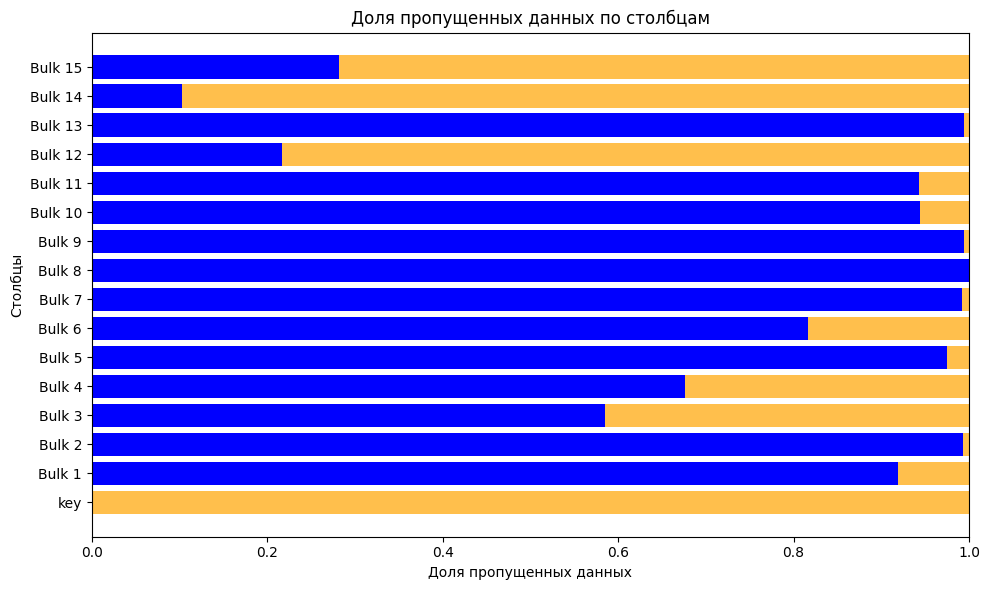

In [15]:
# Calculation of the proportion of missing values
missing_data_ratio = data_bulk.isna().sum() / data_bulk.shape[0]

# Creating a shape and axes
plt.figure(figsize=(10,6))

# Create a horizontal bar chart with orange bars and blue indicators
bars = plt.barh(missing_data_ratio.index, [1] * len(missing_data_ratio), color='orange') 
plt.barh(missing_data_ratio.index, missing_data_ratio, color='blue') 

# Make the columns semi-transparent to visualize the overlay
for bar in bars:
    bar.set_alpha(0.7)


plt.title('Доля пропущенных данных по столбцам')
plt.xlabel('Доля пропущенных данных')
plt.ylabel('Столбцы')
plt.xlim(0, 1) 


plt.tight_layout()
plt.show()

We remove the columns where the proportion of missing values is greater than 80%

In [16]:
cols = data_bulk.columns
for col in cols:
    if data_bulk[col].isna().sum() / data_bulk.shape[0] > 0.8:
        data_bulk = data_bulk.drop(col, axis=1)
        data_bulk_time = data_bulk_time.drop(col, axis=1)

Let's change the data type to datetime:

In [17]:
for col in data_bulk.columns.drop('key'):
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col], format='%H:%M:%S')

Let's process the missing values - since the omission means that the material was not added to the batch, we replace it with zeros

In [18]:
data_bulk = data_bulk.fillna(0)
data_bulk_time = data_bulk_time.fillna(0)

Total:

- Removed columns with missing values greater than 80%
- Processed the skips - replaced with 0

### Table data_gas
This table contains data on gas purging of the alloy.

- `key` - batch number;
- `gas` - volume of gas supplied.

In [19]:
query = '''
SELECT *
FROM steel.data_gas
'''

data_gas = pd.read_sql_query(query, con=engine)
display(data_gas)
data_gas.info()

No skips, let's see the distribution

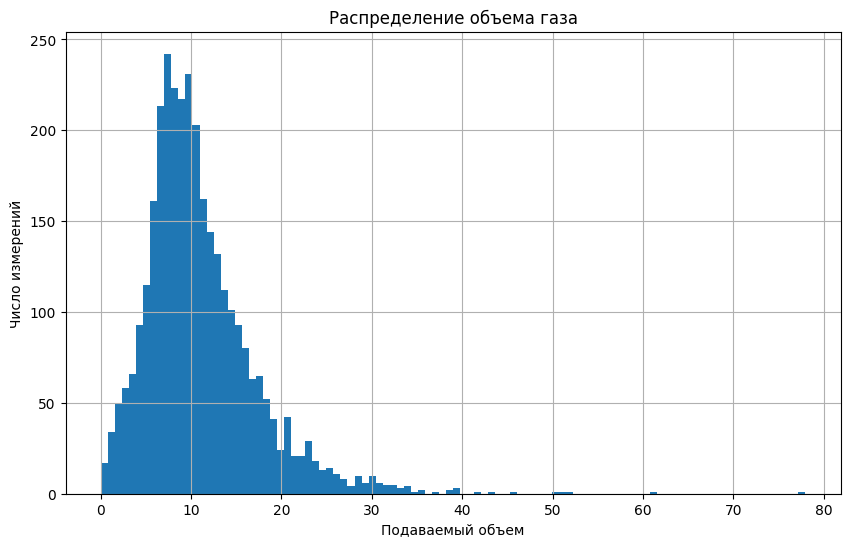

In [20]:
plt.figure(figsize=(10,6))
plt.hist(data_gas['gas'], bins=100)
plt.title('Распределение объема газа')
plt.xlabel('Подаваемый объем')
plt.ylabel('Число измерений')
plt.grid(True);

The graph doesn't show high values well, let's look at the logarithmic scale

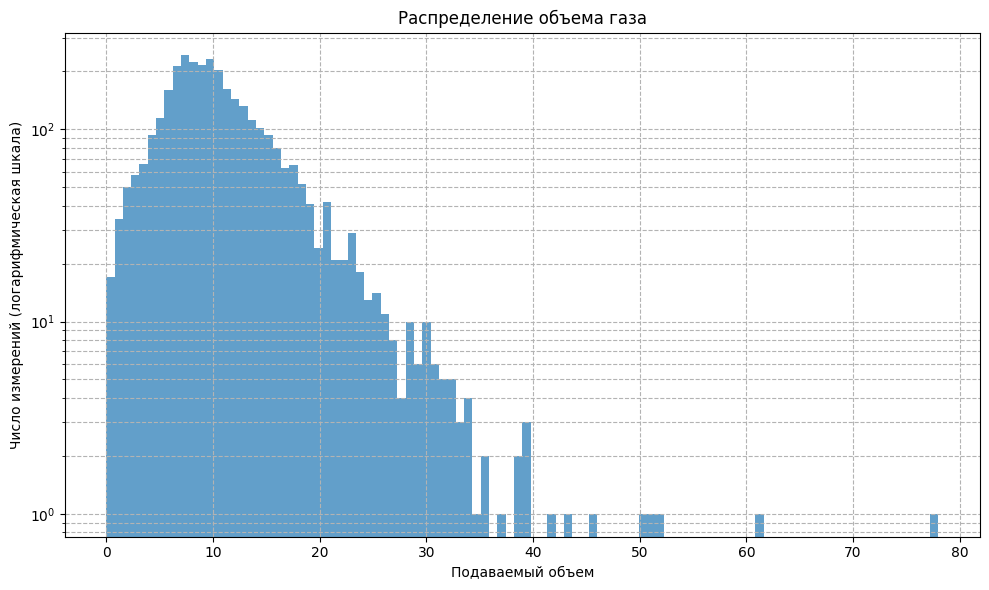

In [21]:
plt.figure(figsize=(10,6))
plt.hist(data_gas['gas'], bins=100, edgecolor='none', alpha=0.7)
plt.title('Распределение объема газа')
plt.xlabel('Подаваемый объем')
plt.ylabel('Число измерений (логарифмическая шкала)')
plt.yscale('log')  
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()


Total

- There are no omissions
- No negative values either
- most of the data is concentrated in the left part of the graph, there are a small number of values exceeding 50. Since we have no data on what to consider as an outlier, let's leave it as it is.

#### Table data_temp
The table contains data on temperature measurements.

- `key` is the batch number;
- `MesaureTime` - time of measurement;
- `Temperature` - temperature value.

In [22]:
query = '''
SELECT *
FROM steel.data_temp
'''

data_temp = pd.read_sql_query(query, con=engine)
display(data_temp)
data_temp.info()

Change the time format

In [23]:
data_temp['MesaureTime'] = pd.to_datetime(data_temp['MesaureTime'], format='%H:%M:%S')

By convention, temperature values below 1500 degrees are anomalous, so let's exclude them, then look at the temperature spread:

In [24]:
data_temp = data_temp.query('Temperature > 1500')

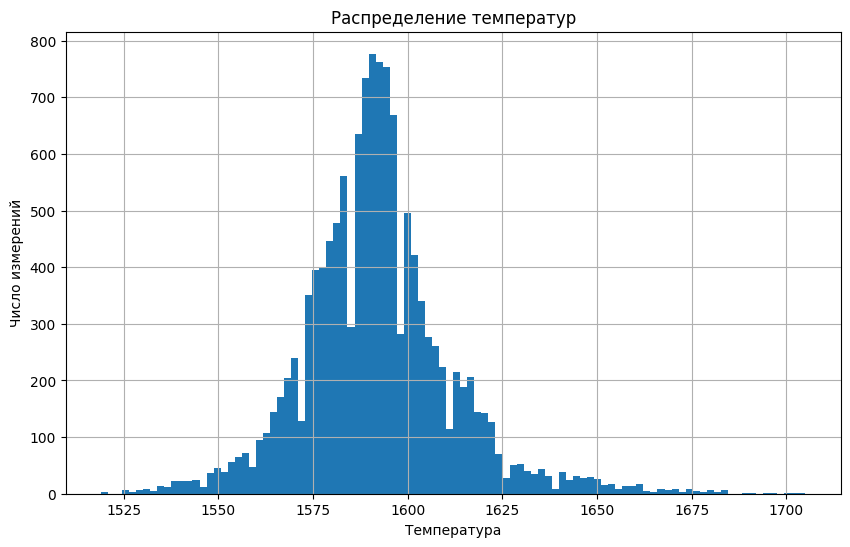

In [25]:
plt.figure(figsize=(10,6))
plt.hist(data_temp['Temperature'], bins=100)
plt.title('Распределение температур')
plt.xlabel('Температура')
plt.ylabel('Число измерений')
plt.grid(True);

We find out the number of measurements per key and leave only the keys that have at least the first and last temperature measurement.

In [26]:
data_temp = data_temp.reset_index(drop=True)

rm = pd.DataFrame(data_temp['key'].value_counts(ascending=True)).reset_index()
rm = rm.rename(columns={'index':'key', 'key':'num'})

data_temp = data_temp.merge(rm, on='key')

In [27]:
data_temp = data_temp.query('num > 1')

According to the problem condition, the target attribute is the last temperature of the batch. The initial temperature of the batch can be used as an input feature. Any other intermediate temperature values will lead to leakage of the target feature, they cannot be used as input. Therefore, for each key, let's keep only the first and last temperature, as well as the measurement time and the number of measurements on each key.

The first and last temperatures will be found by time for each key.

In [28]:
min_time = data_temp.groupby('key')['MesaureTime'].agg('min')
max_time = data_temp.groupby('key')['MesaureTime'].agg('max')

In [29]:
min_time = data_temp.merge(min_time, on='MesaureTime', how='inner')
max_time = data_temp.merge(max_time, on='MesaureTime', how='inner')

Let's join the tables by key and find the measurement time in seconds:

In [30]:
data_temp = min_time.merge(max_time, on='key')
data_temp['MeasureTime'] = (data_temp['MesaureTime_y'] - data_temp['MesaureTime_x']).dt.total_seconds()
data_temp = data_temp.drop(['MesaureTime_x', 'num_x', 'MesaureTime_y'], axis=1)
data_temp = data_temp.rename(columns={'Temperature_x': 'TempFirst', 'Temperature_y': 'TempLast', 'num_y':'IterNum'})

data_temp


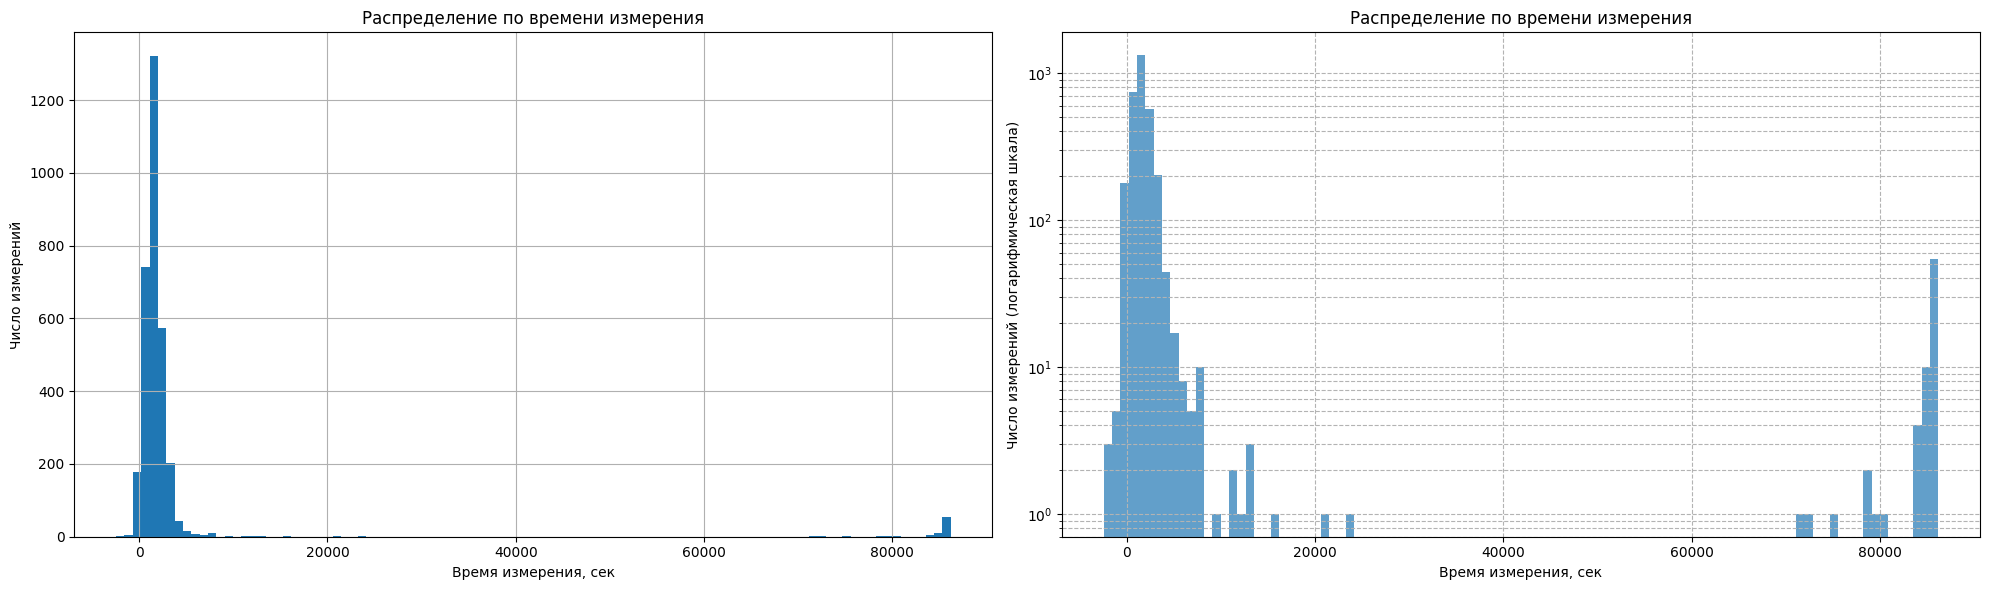

In [31]:
plt.figure(figsize=(20,6))

# First graph - Gas volume distribution
plt.subplot(1, 2, 1)
plt.hist(data_temp['MeasureTime'], bins=100)
plt.title('Распределение по времени измерения')
plt.xlabel('Время измерения, сек')
plt.ylabel('Число измерений')
plt.grid(True);

# Second graph - Distribution by measurement time (logarithmic)
plt.subplot(1, 2, 2)
plt.hist(data_temp['MeasureTime'], bins=100, edgecolor='none', alpha=0.7)
plt.title('Распределение по времени измерения')
plt.xlabel('Время измерения, сек')
plt.ylabel('Число измерений (логарифмическая шкала)')
plt.yscale('log')  
plt.grid(True, which="both", ls="--", c='0.7')

plt.tight_layout()
plt.show()


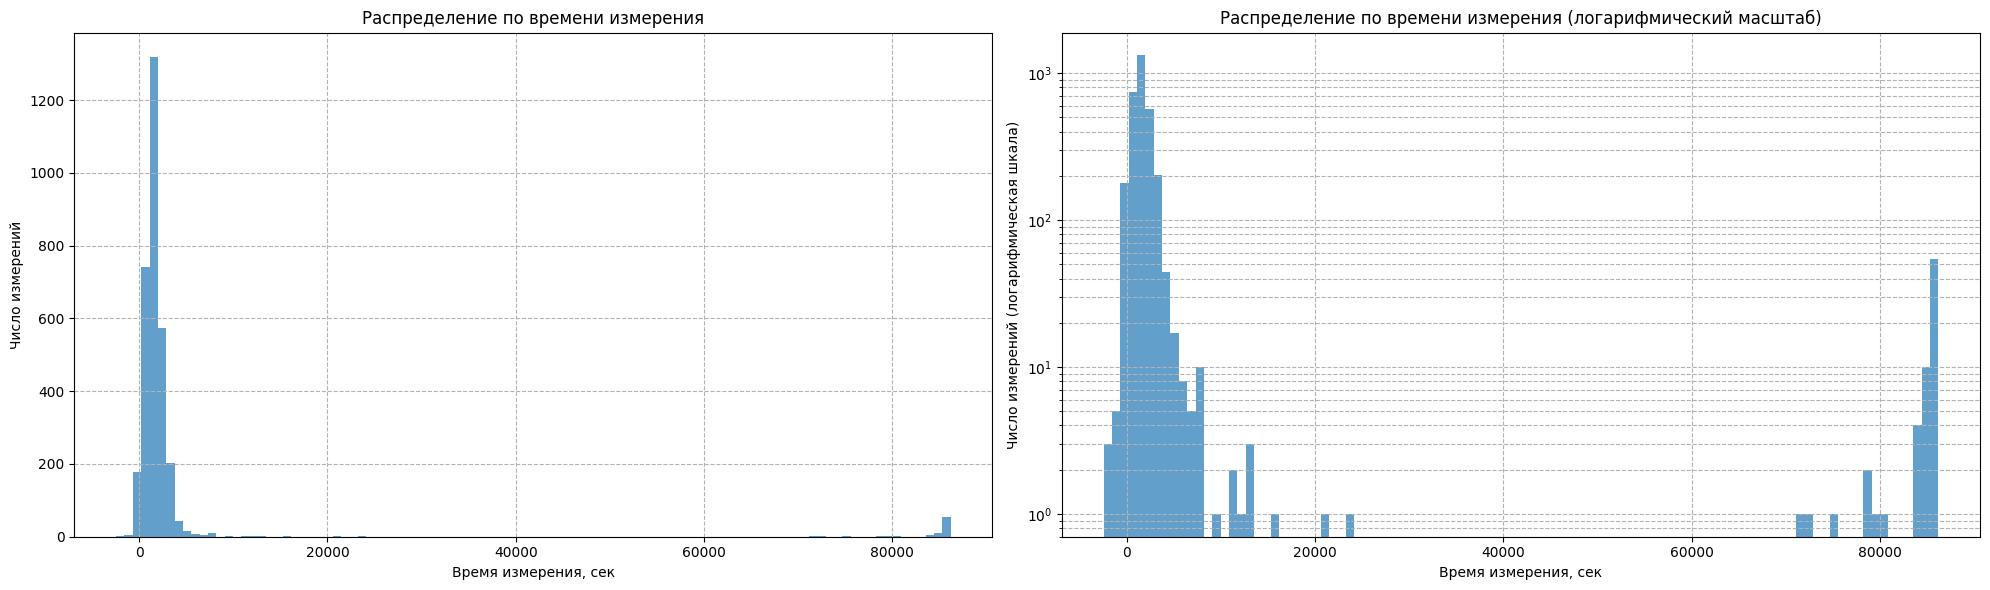

In [32]:
plt.figure(figsize=(20,6))

# First graph - Distribution by measurement time
plt.subplot(1, 2, 1)
plt.hist(data_temp['MeasureTime'], bins=100, edgecolor='none', alpha=0.7)
plt.title('Распределение по времени измерения')
plt.xlabel('Время измерения, сек')
plt.ylabel('Число измерений')
plt.grid(True, which="both", ls="--", c='0.7')

# Second graph - Distribution by measurement time (logarithmic)
plt.subplot(1, 2, 2)
plt.hist(data_temp['MeasureTime'], bins=100, edgecolor='none', alpha=0.7)
plt.title('Распределение по времени измерения (логарифмический масштаб)')
plt.xlabel('Время измерения, сек')
plt.ylabel('Число измерений (логарифмическая шкала)')
plt.yscale('log')  
plt.grid(True, which="both", ls="--", c='0.7')

plt.tight_layout()
plt.show()


Outcome:

- Cleaned up the data by processing outliers
- Removed unnecessary features
- Calculated new features
- We got the final table


#### Tables data_wire and data_wire_time

The tables contain data on the volume and time of wire feeds.

- `key` is the batch number;
- `Wire 1 ... Wire 15` - volume of wire feed.


In [33]:
query = '''
SELECT *
FROM steel.data_wire
'''

data_wire = pd.read_sql_query(query, con=engine)
display(data_wire)
data_wire.info()

In [34]:
query = '''

SELECT *
FROM steel.data_wire_time

'''

data_wire_time = pd.read_sql_query(query, con=engine) 
display(data_wire_time)
data_wire_time.info()

Let's see what proportion of the total are missing values:



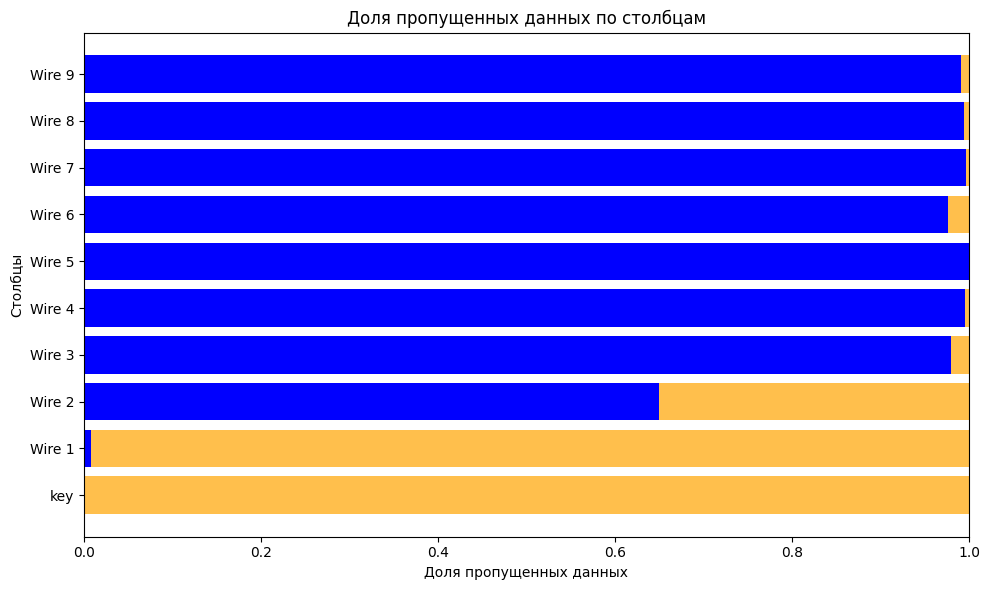

In [35]:
# Calculation of the proportion of missing values
missing_data_ratio = data_wire.isna().sum()/data_wire.shape[0]

# Creating a shape and axes
plt.figure(figsize=(10,6))

# Create a horizontal bar chart with orange bars and blue indicators
bars = plt.barh(missing_data_ratio.index, [1] * len(missing_data_ratio), color='orange')  
plt.barh(missing_data_ratio.index, missing_data_ratio, color='blue')  

# Making columns semi-transparent to visualize the overlay
for bar in bars:
    bar.set_alpha(0.7)


plt.title('Доля пропущенных данных по столбцам')
plt.xlabel('Доля пропущенных данных')
plt.ylabel('Столбцы')
plt.xlim(0, 1)  


plt.tight_layout()
plt.show()

Let's remove columns where the proportion of missing values is more than 80%:



In [36]:
cols = data_wire.columns
for col in cols:
    if data_wire[col].isna().sum()/data_wire.shape[0] > 0.8:
        data_wire = data_wire.drop(col, axis=1)
        data_wire_time = data_wire_time.drop(col, axis=1)

Let's change the data type to datetime:



In [37]:
for col in data_wire.columns.drop('key'):
    data_wire_time[col] = pd.to_datetime(data_wire_time[col], format='%H:%M:%S')

We replace skips with zeros, since a skip indicates that no material was added to this batch.


In [38]:
data_wire = data_wire.fillna(0)
data_wire_time = data_wire_time.fillna(0)

Bottom line:

- processed the missing values
- changed data type

### Merge tables and feature engineering

In [39]:
df = data_arc.merge(data_gas, on='key', how='inner')
df = df.merge(data_temp, on='key', how='inner')
df = df.merge(data_bulk, on='key', how='inner')
df = df.merge(data_wire, on='key', how='inner')
df

We get a summary table containing 17 columns.

In order to get more complete information, we are missing two indicators:

1. Total power is the combination of active power (P) and reactive power (Q). The total power shows the total energy requirement of the system. The total power is calculated using the formula:

$$S = \sqrt{P^2 + Q^2}$$.

2. The power factor determines how much of the total power is active power. It is calculated by the formula:
$$\frac{P}{S}$$.

In [40]:
df['FullPower'] = (df['ActivePower']**2 + df['ReactivePower']**2)**0.5 
df['PowerCoef'] = df['ActivePower'] / df['FullPower']

## Exploratory Data Analysis

Let's look at the correlation of features:



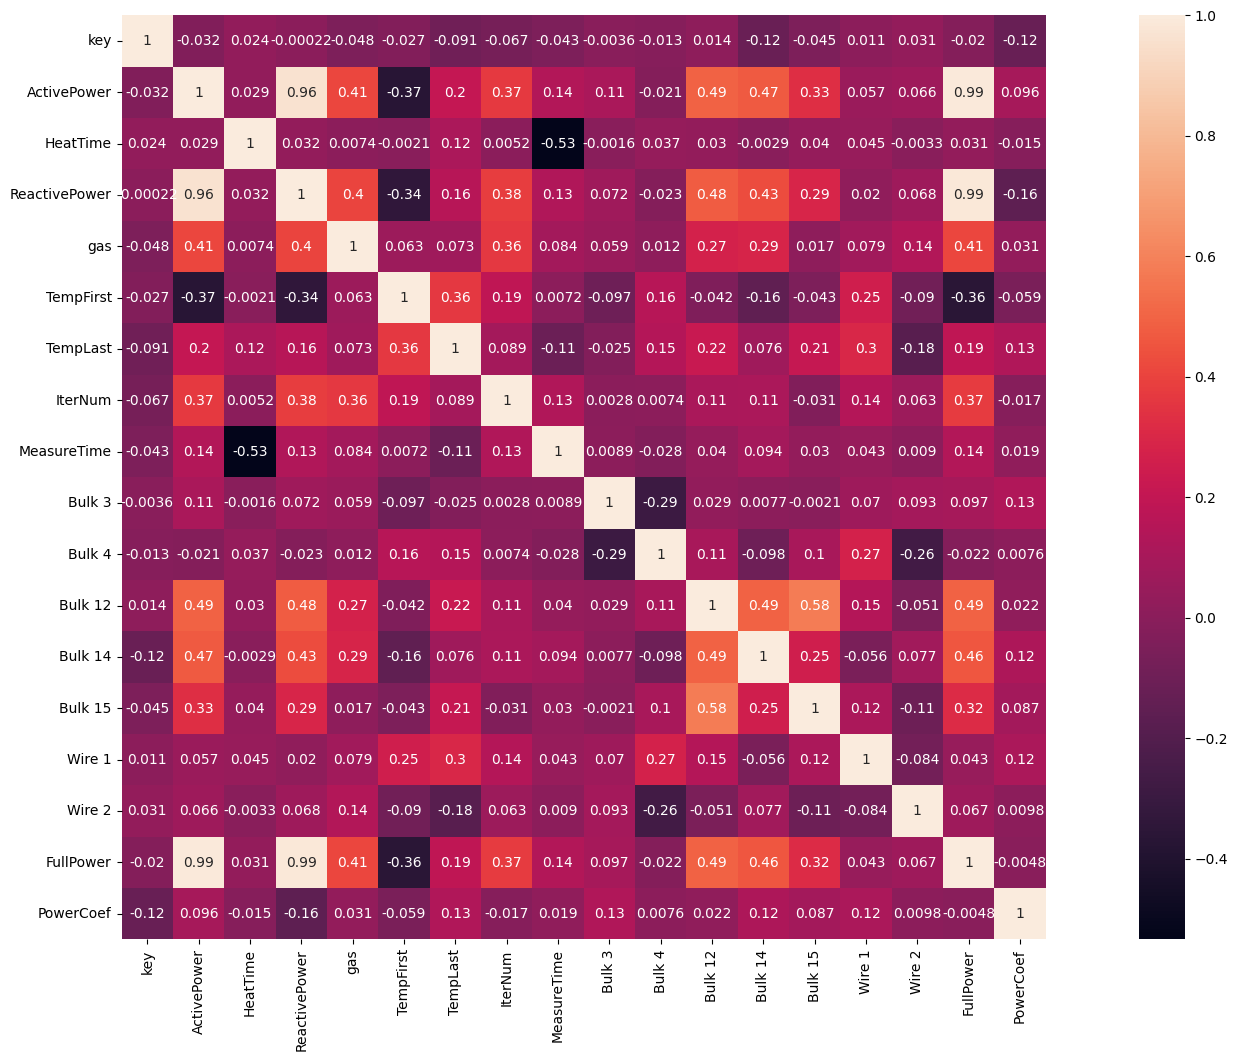

In [41]:
plt.figure(figsize=(24,12))
sns.heatmap(df.corr(),vmax=1,square=True,annot=True);

Based on the provided image of the correlation matrix, the following conclusions can be drawn about the relationship between the features:

**Strong positive correlation (close to 1):**

- `Bulk 12` and `Bulk 14` have a correlation equal to 0.58, indicating a strong positive relationship between these variables.
- `Bulk 15` and `Bulk 12` also show a strong positive correlation with a correlation coefficient of 0.49.

**Moderate and weak positive correlation (0.2 < correlation < 0.8):**

- `Wire 1` and `Wire 2` have a correlation of 0.27, indicating a moderate positive relationship.
- `Bulk 4` and `Bulk 12` with a correlation equal to 0.27 also show a moderate positive relationship.

**Negative correlations:**

- `PowerCoef` and `FullPower` have a correlation equal to -0.4, indicating a moderate negative relationship between these variables.

**Weak or no correlation:**

- Most variables, such as `gas` and `TempFirst` or `TempLast` and `MeasureTime`, have weak or no correlation, as indicated by the light colored cells in the graph.


Let us take into account that correlation does not always indicate a causal relationship between features and that correlation analysis evaluates a linear relationship between variables and cannot always detect non-linear relationships.

Let's remove the features with multicollinearity and the key

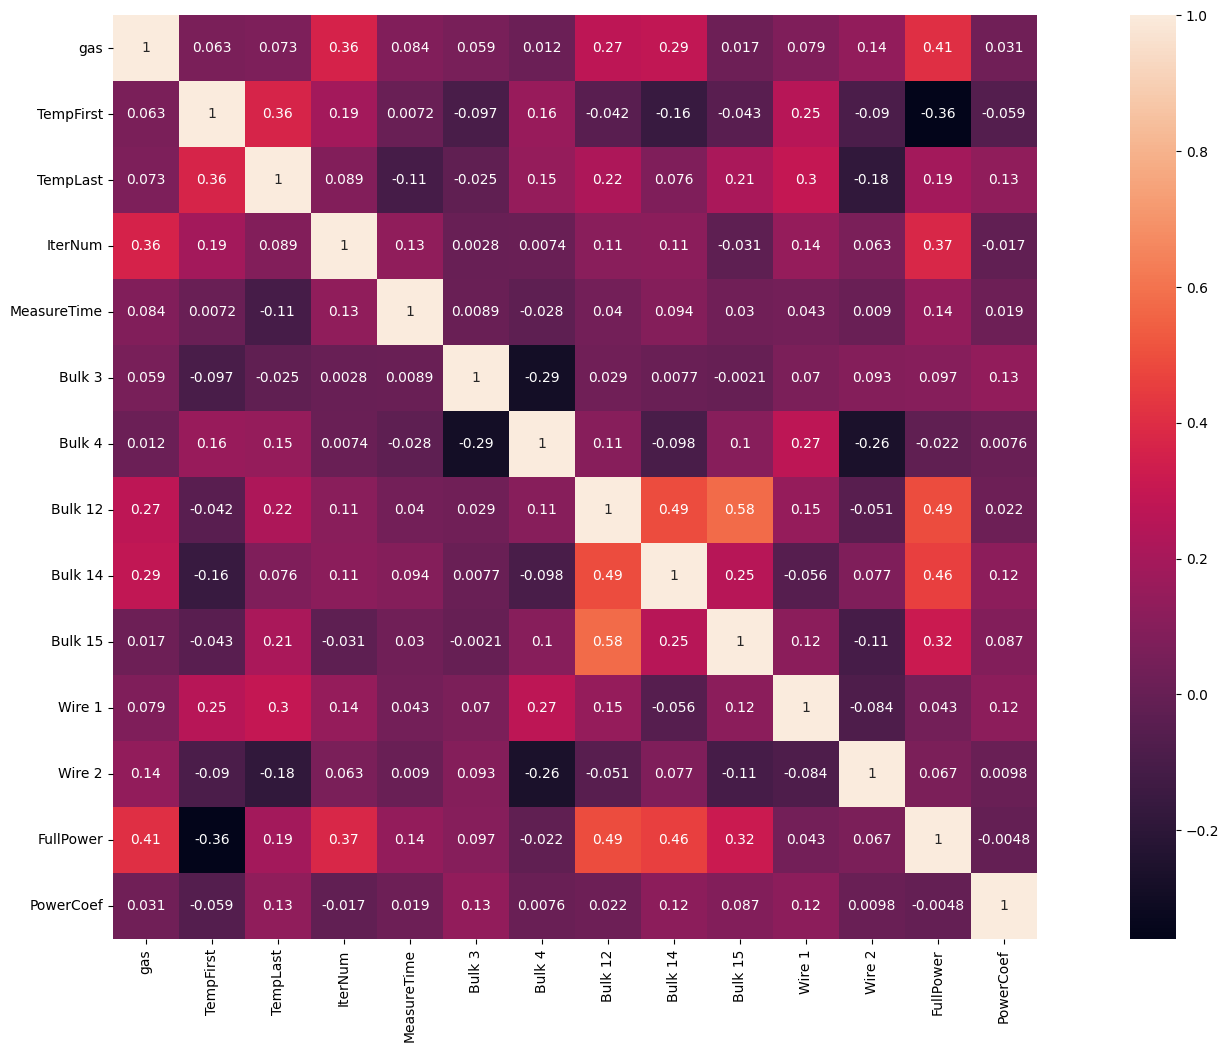

In [42]:
df = df.drop(['ReactivePower', 'ActivePower', 'key', 'HeatTime'], axis=1)

plt.figure(figsize=(24,12))
sns.heatmap(df.corr(),vmax=1,square=True,annot=True);

We can conclude that to the greatest extent the final temperature depends on:

- initial temperature
- full capacity
- the volume of fed wire and bulk materials

Let's look at the final distribution of features:


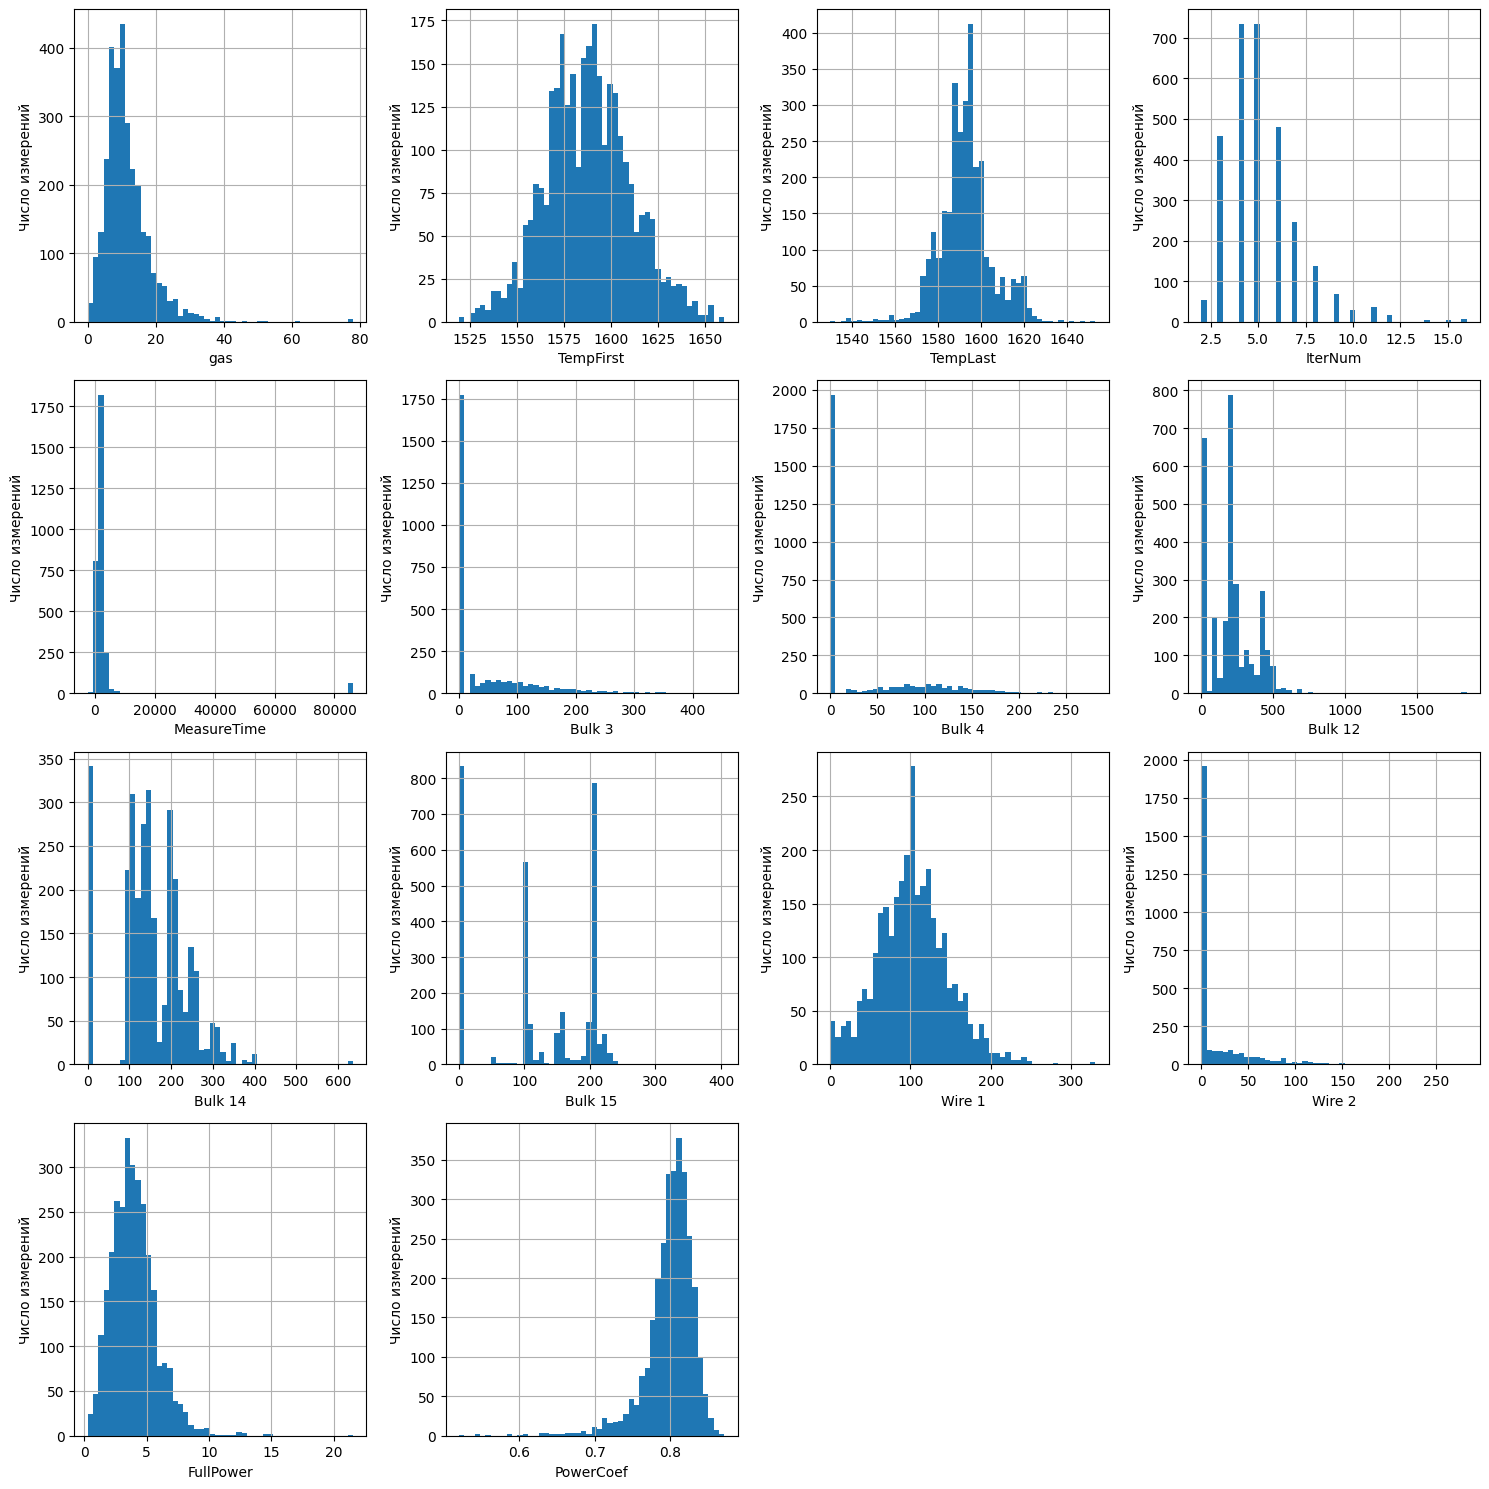

In [43]:
cols = df.columns
num_cols = len(cols)


rows = num_cols // 4 + (1 if num_cols % 4 else 0) 

fig = plt.figure(figsize=(15, 15))
for i in range(num_cols):
    fig.add_subplot(rows, 4, i+1)
    plt.hist(df[cols[i]], bins=50)
    plt.ylabel('Число измерений') 
    plt.xlabel(cols[i])
    plt.tight_layout()
    plt.grid(True)

Based on the provided histograms of feature distribution, the following conclusions can be drawn:

- `gas`: Concentrated around small values with a very high peak around 0. Most of the values are less than 20.

- `TempFirst`: Normal distribution centered around 1560.

- `TempLast`: Mostly centered around the value 1560. There are a few peaks, which may indicate grouping or clustering of the data.

- `IterNum`: Most of the data is concentrated between the values of 2.5 and 7.5.

- `MeasureTime`: Very high peak around 0. Most values are less than 5000.

- `Bulk 3`: Most values fall in the interval up to 100.

- `Bulk 4`: The distribution is heavily skewed towards low values, especially the value 0.

- `Bulk 12`: Similar to Bulk 4, most values are centered around 0.

- `Bulk 14`: Has several peaks, which may indicate grouping of the data.

- `Bulk 15`: The distribution is skewed toward smaller values, most of which are in the range up to 100.

- `Wire 1`: Normal distribution centered around 100.

- `Wire 2`: Most values centered around 0.

- `PowerCef`: The histogram has the appearance of a bimodal distribution with two peaks at about 0.6 and 0.8.

In general, many of the features presented have skewed or multi-peaked distributions. This may indicate that there are different groups or clusters in the data and that some features may be categorical or discrete.

## Model training

### Splitting into samples

In [44]:

X_train, X_test, y_train, y_test = train_test_split(df.drop('TempLast', axis=1), 
                                                     df['TempLast'], 
                                                     test_size=0.25,
                                                     random_state=RANDOM_STATE)



Next, let's do the scaling of the data:



In [45]:
X_train_df = X_train.copy()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [46]:
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train.values)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(y_test.values)


Let's declare a function to find the optimal parameters:



In [47]:
def grid(model, params):
    # Grid search using neg_mean_absolute_error
    grid_mae = RandomizedSearchCV(model,
                                   param_distributions=params, 
                                   scoring='neg_mean_absolute_error', 
                                   n_jobs=-1, cv=5)
    grid_mae.fit(X_train, y_train)
    best_model_mae = grid_mae.best_estimator_  # retrieve the best model

    # Grid search using r2
    grid_r2 = RandomizedSearchCV(model,
                                  param_distributions=params, 
                                  scoring='r2', 
                                  n_jobs=-1, cv=5)
    grid_r2.fit(X_train, y_train)
    best_model_r2 = grid_r2.best_estimator_  # retrieve the best model

    # Evaluate the best model using cross-validation
    cv_scores_mae = cross_val_score(best_model_mae,X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_scores_r2 = cross_val_score(best_model_r2, X_train, y_train, cv=5, scoring='r2')

    # Take the average of the cross-validation scores
    mean_cv_score_mae = round(-1 * cv_scores_mae.mean(), 3) 
    mean_cv_score_r2 = round(cv_scores_r2.mean(), 3)

    print('Средний MAE на кросс-валидации:', mean_cv_score_mae)
    print('Средний R2 на кросс-валидации:', mean_cv_score_r2)
    print('----------------------')
    print('Oптимальные параметры для MAE:\n', grid_mae.best_params_)
    print('Oптимальные параметры для R2:\n', grid_r2.best_params_)

    return mean_cv_score_mae, mean_cv_score_r2


### Linear regression

In [48]:
params =  {}

mae_lr, r2_lr = grid(LinearRegression(), params)

### Decision Tree

In [49]:
params =  {'max_depth': range (1,13, 2),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}

mae_dt, r2_dt = grid(DecisionTreeRegressor(random_state=RANDOM_STATE), params)

### Random Forest ###

In [50]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}
           
mae_rf, r2_rf = grid(RandomForestRegressor(random_state=RANDOM_STATE), params)

### CatBoost

In [51]:
params =  {'depth': range (4,10)}
           
mae_cb, r2_cb = grid(CatBoostRegressor(random_state=RANDOM_STATE, verbose=False), params)

### Torch

First, let's declare an EarlyStopping class that will prevent overtraining and stop the learning loop when the optimal value is reached:

In [52]:
class EarlyStopping():
    def __init__(self, patience=7, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss

            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print('Early stopping')
                self.early_stop = True

We initialize a neural network consisting of input neurons, two hidden layers and an output layer:

In [53]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, 
                 hidden_size3, num_classes):
        
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.Tanh()
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.act3 = nn.Tanh()
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.bn1(out)
        
        out = self.fc2(out)
        out = self.act2(out)
        out = self.bn2(out)
        
        out = self.fc3(out)
        out = self.act3(out)
        out = self.bn3(out)
        
        out = self.fc4(out)
        
        return out
      
    

Let's train the network and get the metrics:



In [54]:
n_in_neurons = X_train.shape[1]
hidden_size_1 = 150
hidden_size_2 = 75
hidden_size_3 = 25
n_out_neurons = 1                                
num_epochs = 1000  

loss = nn.MSELoss() 

batch_size = 10
dataset_train = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
dataset_test = torch.utils.data.TensorDataset(X_test_torch, y_test_torch)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)  
net = Net(n_in_neurons, hidden_size_1, hidden_size_2, hidden_size_3, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=8e-5)

In [55]:
early_stopping = EarlyStopping() 
mae_torch = np.inf 
    
for epoch in tqdm(range(num_epochs)):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch  
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        loss_value.backward()
        optimizer.step()

    predicted_temp = [] 
    with torch.no_grad():
        net.eval()
        for batch in test_dataloader:
            data_test, temperature_test = batch
  
            test_preds = net.forward(data_test).flatten()
            predicted_temp.append(test_preds)
            RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

    predicted_temp = torch.cat(predicted_temp).detach().numpy()
    mae = mean_absolute_error(y_test_torch.detach().numpy(), predicted_temp)
    if mae < mae_torch:
        mae_torch = mae
        best_epoch = epoch
        test_preds_best = predicted_temp
    early_stopping(mae)

    if early_stopping.early_stop:
        break 
mae_torch = round(mae_torch, 3)     
r2_torch = round(r2_score(y_test_torch.detach().numpy(), predicted_temp), 3)
print('MAE:', mae_torch, '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
print('R2:', r2_torch)



### DummyRegressor

To check the adequacy of the model, let's compare it with the constant model:



In [56]:
params =  {}

mae_dummy, r2_dummy = grid(DummyRegressor(strategy='mean'), params)

Let's combine the results into one table and analyze:



In [57]:
d={'MAE':[mae_lr, mae_dt, mae_rf, mae_cb, mae_torch, mae_dummy],
   'R2':[r2_lr, r2_dt, r2_rf, r2_cb, r2_torch, r2_dummy]}

results = pd.DataFrame(data=d, index=['LinearRegression', 
                                      'DescisionTree', 'RandomForest', 
                                      'CatBoost', 'Torch', 'DummyRegressor'])
results.sort_values(by='MAE')

CatBoost's best result is 5.38.


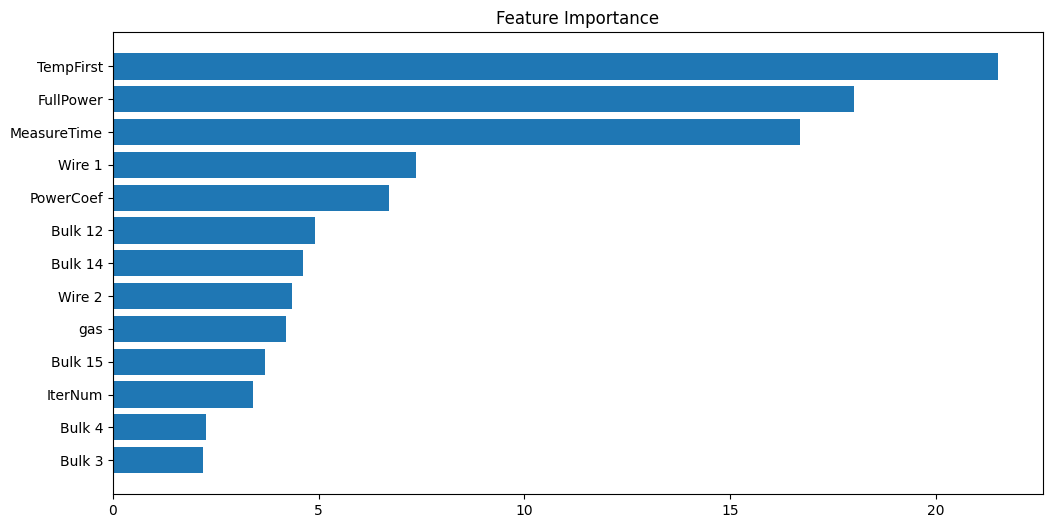

In [58]:
model = CatBoostRegressor(iterations=2500, depth=8,random_state=RANDOM_STATE, verbose=False)
model.fit(X_train, y_train)

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train_df.columns)[sorted_idx])
plt.title('Feature Importance')



The most important feature for the model is the initial temperature.

### Testing the model
Let's test the model on a test sample using optimal parameters - find the MAE and R2 metrics:

In [54]:
predicted_test = model.predict(X_test)
mae = round(mean_absolute_error(y_test, predicted_test), 3)
r2 = round(r2_score(y_test, predicted_test), 3)

print('MAE на тестовой выборке:', mae)
print('R2 на тестовой выборке:', r2)

MAE на тестовой выборке: 5.58
R2 на тестовой выборке: 0.587


## Conclusion

What has been done:

- data loading and transformation
- exploring features in tables
- table merging
- training of models and selection of the best one
- The best MAE result on the test sample was shown by the CatBoost model - 5.85. The R2 value of the model on the test sample is 0.488, which is far from one and indicates that the model may not perform well enough on an unknown data set.

The features most affecting the model's prediction were also identified as.

- initial temperature
- total power
- measurement time

The main problems for the study were:

- large number of outliers and omissions in the data, which negatively affects the prediction
- insufficient amount of data for accurate prediction

